Bayesian ridge regression.

Fit a Bayesian ridge model. See the Notes section for details on this implementation and the optimization of the regularization parameters lambda (precision of the weights) and alpha (precision of the noise).

source [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)

Bayesian regression techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not set in a hard sense but tuned to the data at hand.

This can be done by introducing uninformative priors over the hyper parameters of the model. The  regularization used in Ridge regression and classification is equivalent to finding a maximum a posteriori estimation under a Gaussian prior over the coefficients  with precision . Instead of setting lambda manually, it is possible to treat it as a random variable to be estimated from the data.

more [here](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the Data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Bayesian Ridge

In [8]:
from sklearn.linear_model import BayesianRidge

In [9]:
class ModelEnsembleRegressors():

    def spe(self, y, y_pred): 
        return (y-y_pred)**2
        
    def train(self, df_train):

        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        self.models = {}
        spe_df = pd.DataFrame()
        
        self.to_predict_test = []
        
        for col in df_train.columns:
            
            model = BayesianRidge()
            tr_x = sklearn.preprocessing.scale(df_train.drop([col],axis=1))
            tr_y = sklearn.preprocessing.scale(df_train[col])
        
            model.fit(X=tr_x, y=tr_y)
            
            tr_y_pred = model.predict(X=tr_x)
            
            self.models[col] = model
                                    
            spe_df[col] = self.spe(tr_y, tr_y_pred)
            
            self.to_predict_test.append(col)           
                        
        return np.mean(spe_df, axis=1)
    
    def test(self, df_test):

        spe_df = pd.DataFrame()
        
        for col in self.to_predict_test:
            ts_x = np.array((df_test.drop([col],axis=1)-self.mu_train.drop([col]))/self.std_train.drop([col]))
            ts_y = np.array((df_test[col]-self.mu_train[col])/self.std_train[col])
            ts_y_pred = self.models[col].predict(ts_x)
            spe_df[col] = self.spe(ts_y, ts_y_pred)
                
        return np.mean(spe_df, axis=1)

## Noise filtering

In [10]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Training the Data

In [11]:
models = {'BayesRidge': ModelEnsembleRegressors()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

## Testing the Data

BayesRidge    61.675
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
BayesRidge,99.375,98.125,0.0,92.875,13.875,100.0,100.0,96.625,0.0,33.25,41.125,95.25,90.25,99.75,0.0,31.375,80.75,92.0,31.5,37.375


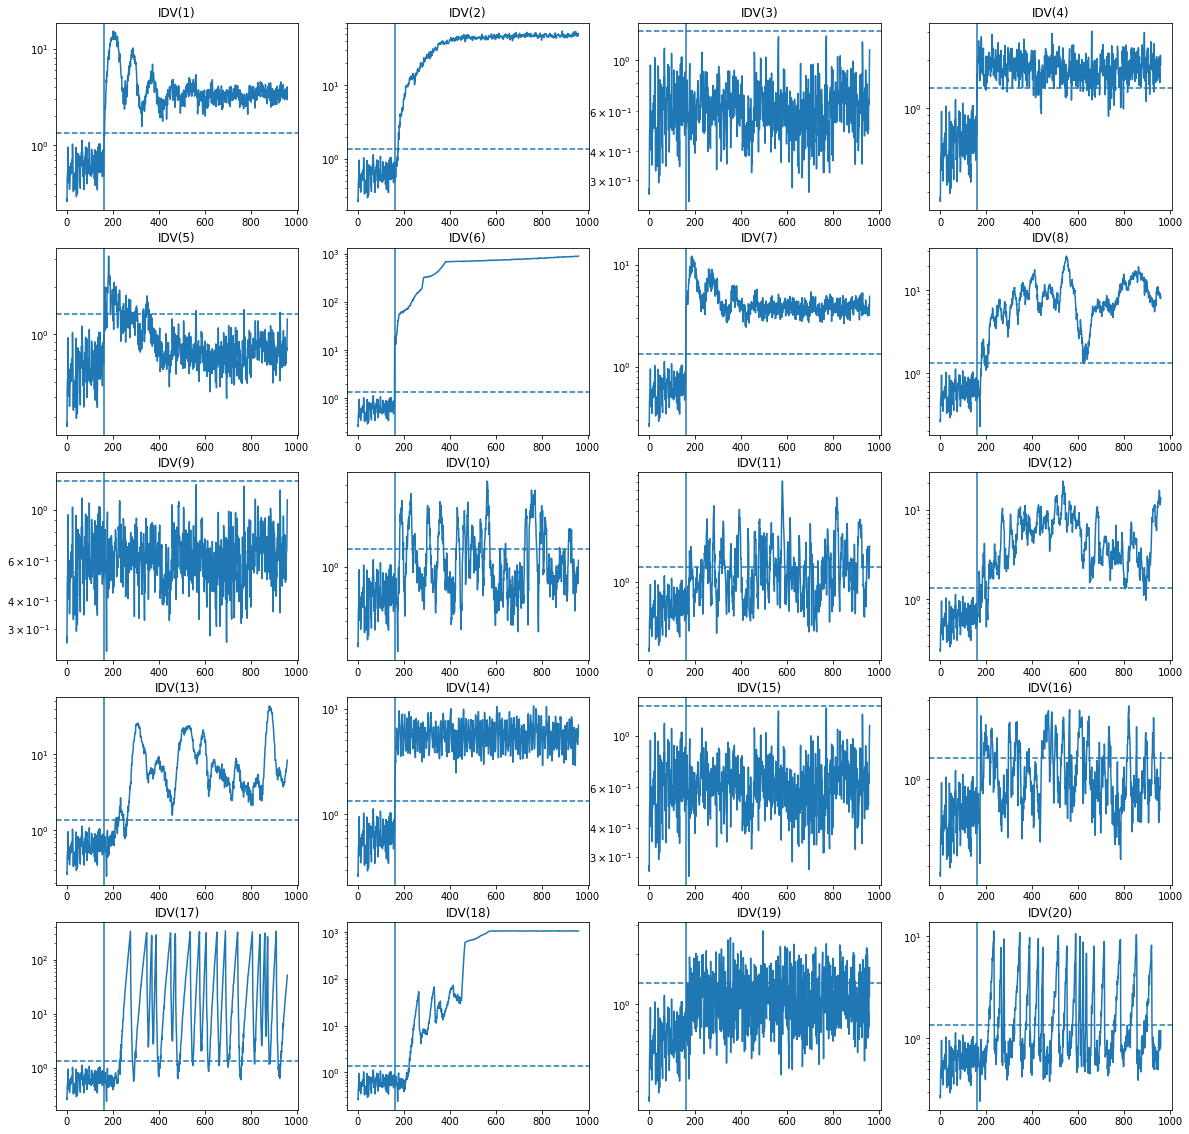

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

## FIlter noise

WS_10     68.03125
WS_50     64.65625
WS_100    59.06250
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.500,98.250,0.625,99.625,99.625,100.000,99.75,97.625,0.875,32.125,80.125,97.875,94.125,43.500,0.5,48.0,91.000,92.875,22.250,62.375
WS_50,98.750,97.125,0.000,99.000,97.875,99.750,99.25,97.125,0.000,35.375,74.750,89.375,92.750,0.000,0.0,30.5,90.250,91.125,7.125,93.000
WS_100,97.875,96.000,0.000,98.250,96.625,99.125,98.25,87.000,1.125,8.125,51.500,81.500,90.500,2.125,0.0,0.0,89.875,90.500,0.875,92.000


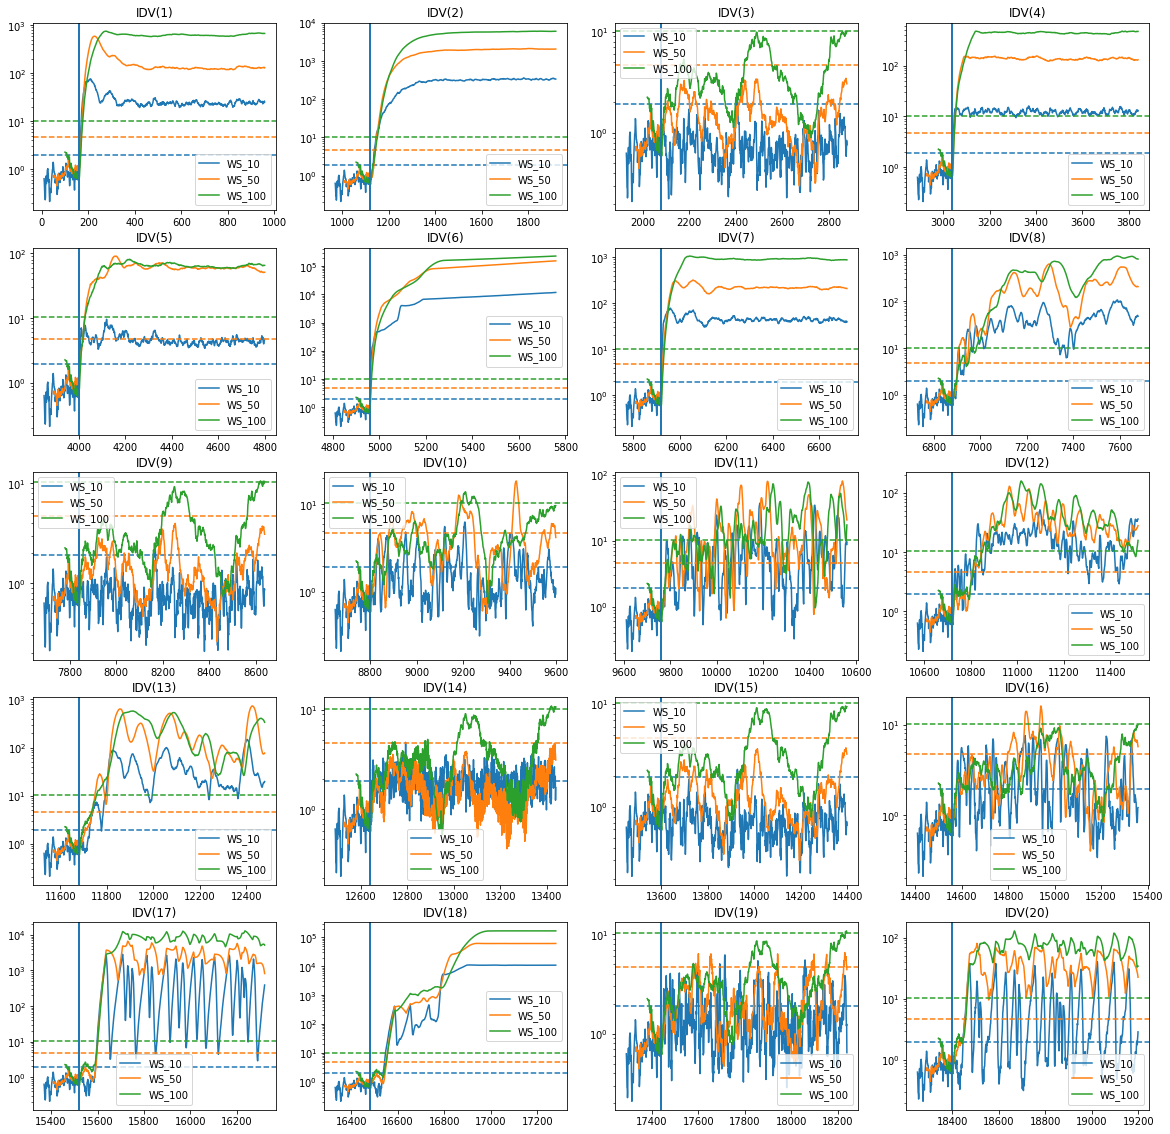

In [13]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelEnsembleRegressors(), 'WS_50': ModelEnsembleRegressors(), 'WS_100': ModelEnsembleRegressors()}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T